In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
import datetime

# Gaining a deeper understanding of fitting model parameters

### Introduction 
Throughout the course we have explored fitting model parameters to data. In particular, we fit a linear model with two parameters, a slope and an offset, to data describing the excess photon counts from the Vela pulsar.

The goal of this project is to deepen the understanding of the math behind the fitting.  To keep the math simple, we will revisit the same data, but we will simplify the model by removing the slope, so that we are only fitting for the offset. 

Recall that in order to fit the model to data, we need to minimize the $\chi^2$ function. The $\chi^2$ is given by:

$\chi^2 = \sum_i (\frac{n_i - m_i(x)}{\sigma_i})^2,$

where $n_i$ is the number of counts from week $i$ (i.e., 'excess_counts' in the next cell) and $\sigma_i$ is uncertainty on that number (i.e., 'sigma_counts' in the next cell). $m_i$ is the model prediction.

In our case the model prediction is simple. $m(x) = p_0$, so $\chi^2$ reduces to:

$\chi^2 = \sum_i (\frac{n_i - p_0}{\sigma_i})^2.$


### Potential goals for this project:

1. Take the first and second partial derivatives of the $\chi^2$ with respect to $p_0$. Write out your own expression of the first and second derivatives of $\chi^2$ with respect to $p_0$.  Implement them as functions, plot them, and verify your results by comparing them to the functions that we wrote to compute the derivatives numerically.

2. Explicitly solve for the formula for the best fit value of $p_0$, and the uncertainty on $p_0$ ($\sigma_{p_0}$).  This will give you an expressing for $p_0$ in terms of the $n_i$ and $\sigma_i$. Show your work. 
    - Hint: Remind yourself from a previous week how the uncertainty relates to the change in the $\chi^2$ function with respect to the minimum value). Note you can show that $\Delta \chi^2$ as $\Delta \chi^2 = a (\sigma_{p_0})^2$.  For this step, demonstrate that for our case $a = \frac{1}{2} \frac{\partial^2\chi^2}{\partial p_0^2}$.

3. Compare the formulas you derived for $p_0$ and $\sigma_{p_0}$ to the formulas for taking the weighted average of the data points by inverse variance weighting. 

4. Implement your formulas for the best-fit values of $p_0$ and $\sigma_{p_0}$ as functions, evaluate them, and compare the values to those found by a built-in optimizer like `scipy.optimize`.

Try to complete all of these goals (or similar goals if you have your own ideas). Be sure to give detailed explanations of the plots produced and an explanation of the results for each of the goals. If you don't want to type up your math work, you can write it out on a piece of paper and include it as an picture in your report.

Tips:
- You may want to use `plt.legend()`, as well as the plotting option [`alpha`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html), which controls the transparency of the plot markers and takes a value between 0 and 1, for plotting the analytical and numerical derivative results on the same canvas.


# Project details

### Load data

In [100]:
data = np.loadtxt(open("../data/Vela_Flux.txt", 'rb'), usecols=range(7))

# This is how we pull out the data from columns in the array.

# This is the date in "Mission Elapsesd Time"
# For the Fermi mission, this is defined to be the number of seconds since the start of 2001.
date_MET = data[:,0]
# This is the offset in seconds between the Fermi "MET" and the UNIX "epoch" used by matplotlib
MET_To_Unix = 978336000

# These are the numbers of photons observed from Vela each week in the "low" Energy Band (100 MeV - 800 MeV)
nObs_LE = data[:,1]

# These are the number of photons expected from Vela each week, under the assumption that it is 
# not varying at all, and the only differences depend on how long we spent looking at Vela
# that particular weeek
nExp_LE = data[:,2]

# These are the band bounds, in MeV
LE_bounds = (100., 800.)

# This is the "significance" of the variation for each week.  We will discuss this more later
signif_LE = data[:,3]

# This converts the dates to something that matplotlib understands
dates = [datetime.datetime.fromtimestamp(date + MET_To_Unix) for date in date_MET]
date_YEAR = 2001 +  (date_MET / (24*3600*365))
years_since_mid_2014 = date_YEAR  - 2014.5

excess_counts = nObs_LE-nExp_LE
sigma_counts =  np.sqrt(nObs_LE)

### Define the model and the cost function

This next cell defines the model and the cost function

In [101]:
def constant_function(xvals, params):
    return params[0]

def residual_function(data_x, data_y, model_function, params):
    model_y = model_function(data_x, params)
    residual = data_y - model_y
    return residual

def chi2_function(data_x, data_y, data_sigma_y, model_function, params):
    model_y = model_function(data_x, params)
    chi2 = ((data_y - model_y)/(data_sigma_y))**2
    return np.sum(chi2)

def cost_function(params):
    return 0.5*chi2_function(years_since_mid_2014, excess_counts, sigma_counts, constant_function, params)

def plot_data(dates, excess_counts, sigma_counts, p0, p0err):
    _ = plt.errorbar(dates, excess_counts, sigma_counts)
    _ = plt.errorbar(dates, np.ones(len(dates))*(p0-p0err), np.ones(len(dates))*(p0+p0err))
    _ = plt.xlabel(r'Date [year]')
    _ = plt.ylabel(r'Counts')

# Fitting the data for $p_0$, the offset number of counts

This next cell fits the model, prints out the result, and plots both the data and the best fit.

Fitter result:
      fun: 382.2499943497748
 hess_inv: array([[4.3492921]])
      jac: array([3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([-1.68807772])

Human readable version ---------------
  p0 best fit value: -1.7 +- 2.1 counts
  Minimum value of cost function: 382.2
  Minimum value of chi**2: 764.5


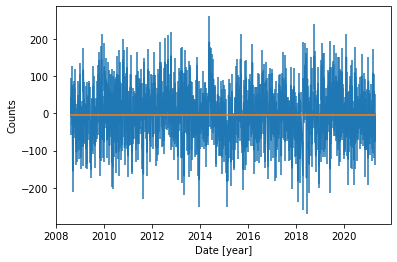

In [102]:
result = optimize.minimize(cost_function, x0=[0.])
pars = result['x']
fmin = result['fun']
p0_best = pars[0]
cov = result['hess_inv']
p0_err = np.sqrt(cov[0,0])

print("Fitter result:")
print(result)

print("")
print("Human readable version ---------------")
print("  p0 best fit value: %.1f +- %.1f counts" % (p0_best, p0_err))
print("  Minimum value of cost function: %.1f" % fmin)
print("  Minimum value of chi**2: %.1f" % (2*fmin))

plot_data(dates, excess_counts, sigma_counts, p0_best, p0_err)

### Numerical derivatives and associated plots

These functions will compute the derivatives of the $\chi^2$ with respect to $p_0$, and produce plots of them as a function of $\chi^2$.

In [103]:
def chi2_scan(cost_func, xvals):
    chi2_vals = np.zeros(xvals.shape)
    for i, xv in enumerate(xvals):
        chi2_vals[i] = 2*cost_func([xv])
    return chi2_vals

def numerical_deriv(cost_func, xvals):
    dx = np.mean(xvals[1:] - xvals[:-1]) / 50.
    chi2_0 = chi2_scan(cost_func, xvals)
    chi2_1 = chi2_scan(cost_func, xvals + dx)
    return (chi2_1 - chi2_0)/dx

def numerical_2nd_deriv(cost_func, xvals):
    dx = np.mean(xvals[1:] - xvals[:-1]) / 50.
    deriv_0 = numerical_deriv(cost_func, xvals)
    deriv_1 = numerical_deriv(cost_func, xvals + dx)
    return (deriv_1 - deriv_0)/dx

def plot_chi2(cost_func, xvals):
    yvals = chi2_scan(cost_function, xvals)
    _ = plt.plot(xvals, yvals)
    _ = plt.xlabel(r'$p_0$ [counts]')
    _ = plt.ylabel(r'$\chi^2$')
    
def plot_dchi2_dp0(cost_func, xvals):
    yvals = numerical_deriv(cost_function, xvals)
    _ = plt.plot(xvals, yvals)
    _ = plt.xlabel(r'$p_0$ [counts]')
    _ = plt.ylabel(r'First Derivative: $\frac{\partial\chi^2}{\partial p_0}$')
    
def plot_d2chi2_dp02(cost_func, xvals):
    yvals = numerical_2nd_deriv(cost_function, xvals)
    _ = plt.plot(xvals, yvals)
    _ = plt.xlabel(r'$p_0$ [counts]')
    _ = plt.ylabel(r'Second Derivative: $\frac{\partial^2\chi^2}{\partial p_0^2}$')
    _ = plt.ylim(-1, 1)

# This is the grid we will use for plotting
xvals = np.linspace(-10, 10, 101)

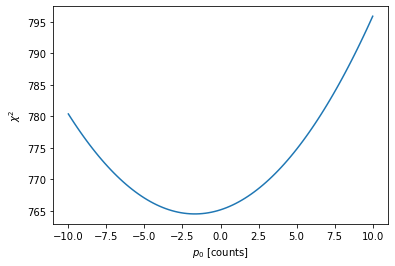

In [104]:
plot_chi2(cost_function, xvals)

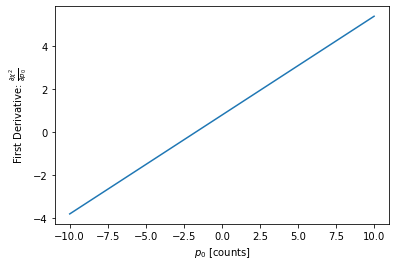

In [105]:
plot_dchi2_dp0(cost_function, xvals)

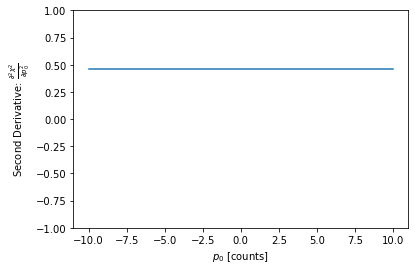

In [106]:
plot_d2chi2_dp02(cost_function, xvals)